What *cluster_alignment.py* does:

The goal is to learn a predictive model, which assigns to any cell (i.e., gene expression vector on the gene panel) its most probable cluster number among those determined on whole scRNA sequencing data.

#### Model training

The training data is a subset of the whole scRNAseq gene expression matrix (on all samples, that is, all conditions and ages), restricted to genes which belong to the panel in targeted scRNA data ($N=46$). The training pipeline and the model are implemented in Python 3.6, using package scikit-learn [1] (version 0.24.2).

##### Data processing

Whole scRNAseq gene expression matrix is standardized using routine *StandardScaler* in scikit-learn, that is, if X is the matrix:

$$\tilde{X} := (X-\text{mean}(X))/\text{std}(X-\text{mean}(X))\;,$$
where mean (resp., std) is the function computing the mean (resp., the standard deviation) on the array comprising of all values contained in the matrix in argument.

##### Model

The considered model is a logistic (logit) model. If $x=[x_1, x_2, \dots, x_{L-1}, x_{L}]^\top$ is a gene expression vector on $L=46$ genes, let us denote the set of $L+1$ coefficients (including the intercept) in the model associated with any cluster $C \in \{0,1,2,\dots,7\}$ $\beta^C_0$, $\beta^C_1$, $\dots$, $\beta^C_{L-1}$, $\beta^C_{L}$. Then the probability of the associated cell of belonging to cluster $C$ is
$$Pr(x \text{ in } C | \beta^C_{\cdot}) := \frac{1}{1+\exp(-(\beta^C_0+\beta^C_1 x_1+\dots+\beta^C_{L-1} x_{L-1}+\beta^C_L x_L))}\:.$$

##### Model fitting

Given a list of N whole scRNA gene expression vectors (from the standardized whole scRNAseq matrix) and associated cluster numbers $(x^i, y^i), i=1,2,\dots$ (training data), the model fitting step consists to estimating the values of the $L=46$ coefficients $\beta^C_0$, $\beta^C_1$, $\dots$, $\beta^C_{L-1}$, $\beta^C_{L}$ for each cell cluster $C \in \{0,1,2,\dots,7\}$. We consider a $l_1$ (also called lasso) regularization, that is, the estimated set of parameters $\beta^{\cdot}_{\cdot}$ for all clusters and genes would minimize the following function 
$$\text{loss}(\beta^{\cdot}_{\cdot}) := - \sum_{\text{cluster } C} \ \sum_{\substack{\text{sample }x^i,\\\text{ s.t. cluster }y^i=C}} \  \log(Pr(x^i \text{ in } C | \beta^C_{\cdot}))+\sum_{\text{cluster } C} \ \sum_{\substack{\text{gene }\\g=1,2,\dots,L}} |\beta^{C}_{g}|\:.$$

$L \times  8$ (\#clusters) coefficients are estimated in total.

To perform model fitting, we have used the *Logistic_Regression* class in scikit-learn, with tolerance parameter$=10^{-4}$, random seed$=0$, maximum number of iterations$=2000$, and the SAGA solver.
           
##### Training procedure

We have split the samples in the whole scRNAseq gene expression matrix into two groups, the training and the testing sets, where the testing set represents $5%$ of the total number of samples. The logistic model is fitted on the training set, and the values of Area Under the Curve (AUC) and Adjusted Rand Score (ARI) reported below are computed on cluster predictions on the testing set, compared to the ground truth cluster numbers for samples in the testing set. We performed a $5-$fold cross-validation procedure, and selected the model with the highest AUC across all cross-validation phases.

#### Application to targeted scRNA data

Targeted scRNA gene expression matrix is restricted to the $L=46$ genes identified in the training phase. Then it is standardized (using routine *StandardScaler* in scikit-learn), and the fitted logistic model is run to get the cluster predictions for targeted scRNAseq samples.

#### References

[1] Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." the Journal of machine Learning research 12 (2011): 2825-2830.

[2] Defazio, Aaron, Francis Bach, and Simon Lacoste-Julien. "SAGA: A fast incremental gradient method with support for non-strongly convex composite objectives." Advances in neural information processing systems 27 (2014).

# Cellular cluster prediction model: analysis

## Model predictive power

In [1]:
import pickle as pkl
import subprocess as sb
import pandas as pd

rfolder="results_targeted_standard__LogisticRegression/"
dfolder="DATA/"

with open(rfolder+"LogisticRegression_model.pck", "rb") as f:
    model = pkl.load(f)

auc, ari = model["AUC (test)"], model["ARI (test)"]
res_str = "Model achieved AUC = %.3f (very good predictive power)"
res_str += "\nand ARI = %.3f (quite good clustering similarity) on the 5 perc. testing set"
print(res_str % (auc, ari))
logit_model = model["estimator"]

Model achieved AUC = 0.923 (very good predictive power)
and ARI = 0.452 (quite good clustering similarity) on the 5 perc. testing set


In [2]:
print("Restricted to microglia clusters (/!\ on the WHOLE dataset, not only on testing data)")
microglia = list(map(str,[0,1,2,3,5]))

from cluster_alignment import data_normalisation
from sklearn.metrics import adjusted_rand_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from params import *

with open(rfolder+"LogisticRegression_model.pck", "rb") as f:
    model = pkl.load(f)
clf = model["estimator"]

with open(rfolder+"gene_list.pck", "rb") as f:
    di = pkl.load(f)
whole_panel = di["whole_panel"]
info_experience = pd.read_csv(dfolder+dfolder_files["metadata_whole"], index_col=0)
counts = pd.read_csv(rfolder+"raw_counts_subset_feature.csv", index_col=0)
counts = counts[[i for i in info_experience.index if (i in counts.columns)]].loc[whole_panel].dropna().T

## Clustering on whole data (true)
clustering_whole = pd.read_csv(dfolder+dfolder_files["metadata_whole"], index_col=0).loc[counts.index][["seurat_clusters"]].astype(str).values.flatten().ravel()

_, X_pred_fit = data_normalisation(counts, "standard", counts)

ids_microglia = np.array([i for i, c in enumerate(clustering_whole) if (c in microglia)])
X_pred_fit_microglia = X_pred_fit[ids_microglia,:]
clustering_whole_microglia = clustering_whole[ids_microglia]

def print_metrics(Y, X_pred_fit, clf, type_):
    Y_pred = clf.predict(X_pred_fit).ravel()
    lab = LabelBinarizer().fit(Y)
    Y_bin, Y_predbin = lab.transform(Y), lab.transform(Y_pred)
    print("On clusters %s" % str(list(np.unique(Y))))
    auc = roc_auc_score(Y_bin, Y_predbin, multi_class="ovr", average="weighted", labels=list(np.unique(Y)))
    ari = adjusted_rand_score(Y, Y_pred)
    return "(%s) ARI = %.3f, AUC = %.3f" % (type_, ari, auc)

## Clustering on whole data (predicted) on microglia
print(print_metrics(clustering_whole_microglia, X_pred_fit_microglia, clf, "microglia"))

## Clustering on whole data (predicted) on microglia
print(print_metrics(clustering_whole, X_pred_fit, clf, "whole"))

Restricted to microglia clusters (/!\ on the WHOLE dataset, not only on testing data)
On clusters ['0', '1', '2', '3', '5']
(microglia) ARI = 0.444, AUC = 0.818
On clusters ['0', '1', '2', '3', '4', '5', '6', '7']
(whole) ARI = 0.437, AUC = 0.815


## Gene panel in model

In [3]:
rfolder="results_targeted_standard__LogisticRegression/"

with open(rfolder+"gene_list.pck", "rb") as f:
    targeted_panel = pkl.load(f)["targeted_panel"]

get_genes = lambda x : sb.check_output("cat "+x+".csv | cut -d',' -f1", shell=True).decode("utf-8").split("\n")[1:-1]
targeted_genes = get_genes(dfolder+"final_targeted.csv")

print("Targeted data gene panel (#genes = %d):\n" % len(targeted_panel))
for g in list(sorted(targeted_panel)):
    print(g)
missing = list(set(targeted_genes).difference(set(targeted_panel)))
print("\nMissing genes from initial panel (N=%d) = %s" % (len(missing),str(missing)))

Targeted data gene panel (#genes = 46):

ApoE
Bcl2l1
Ccl12
Ccl2
Ccl3
Ccnd1
Cd14
Cd74
Cd9
Cldn5
Clec7a
Col1a2
Ctsd
Fabp5
Gpnmb
Gpr84
Hmgb2
Icam1
Ifngr1
Igfbp2
Il1b
Il4Ra
Itgax
Jak3
Lyve1
Lyz2
Map3k8
Meg3
Mif
Mki67
Mrc1
Nfkb1
P2ry12
Pf4
Pim1
Ptprz1
Rab7b
Rgs5
S100a9
Socs3
Sparc
Spp1
Stat3
Tnfaip3
Ttr
Ube2c

Missing genes from initial panel (N=0) = []


## Visualization of model coefficients

In [4]:
import matplotlib.pyplot as plt
from copy import copy
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage

def compute_cluster_dendrogram(clf, restrict_to=None, plot_it=False):
    classes = clf.classes_
    coefs = clf.coef_
    if (restrict_to is None):
        restrict_to = classes
    clusters_ids = [i for i,c in enumerate(classes) if (c in restrict_to)]
    ## sort columns by variance
    vars_clusters = np.var(coefs[clusters_ids], axis=0)
    gene_order = list(reversed(list(np.argsort(vars_clusters))))
    mat = logit_model.coef_[clusters_ids, :]
    mat = mat[:,gene_order]
    ## sort rows by cluster proximity
    linkage_data = linkage(mat, method='ward', metric='euclidean')
    cluster_order = list(dendrogram(linkage_data, 
                    labels=["C%s"%classes[i] for i in clusters_ids],
                    leaf_rotation=90)["leaves"])
    if (plot_it):
        plt.show()
    plt.close()
    mat = mat[cluster_order,:]
    return mat, vars_clusters, gene_order, cluster_order, linkage_data

def plot_feature_by_variance(mat, vars_clusters, gene_order, targeted_panel, name="", figsize=(12,3), ylim=(-5,25)):
    plt.figure(figsize=figsize)
    plt.title("Variation of gene-specific coefficient in model across %s cell clusters" % name)
    plt.boxplot(mat)
    plt.plot(range(1,mat.shape[1]+1), vars_clusters[gene_order], "b-", alpha=0.4, label="Variance curve")
    plt.plot([6.5,6.5], [np.min(mat), np.max(vars_clusters)], "r--", alpha=0.4, label="Elbow point in variance curve")
    plt.xticks(range(mat.shape[1]+1), [""]+[targeted_panel[i] for i in gene_order], rotation=90)
    plt.ylabel("Coefficient value across clusters")
    plt.xlabel("Genes")
    plt.ylim(ylim)
    plt.legend()
    plt.show()
    plt.close()

    print("\t".join(["Gene"]+[targeted_panel[i] for i in gene_order[:6]]))
    print('\t'.join(["Var."]+[str(i) for i in np.round(vars_clusters[gene_order[:6]],2)]))
    
def plot_feature_coefficient(mat, vars_clusters, gene_order, cluster_order, targeted_panel, name="", figsize=(40,40)):
    plt.figure(figsize=figsize)
    plt.title("Gene-specific coefficient in model across %s cell clusters" % name)
    c_map = copy(cm.get_cmap("coolwarm"))
    c_map.set_over('k')
    plt.imshow(mat, cmap=c_map, vmin=-2.5, vmax=2.5, interpolation='none')
    plt.xlabel("Genes")
    plt.ylabel("Clusters")
    plt.xticks(range(mat.shape[1]), [targeted_panel[i] for i in gene_order], rotation=90)
    plt.yticks(range(mat.shape[0]), ["C%s"%i for i in cluster_order])
    plt.colorbar(shrink=0.25, extend='max')
    plt.savefig("gene_coefficient.png", bbox_inches="tight", dpi=1200)
    plt.show()
    plt.close()
    
def plot_cluster_heatmap(mat, vars_clusters, gene_order, targeted_panel, linkage_data, figsize=(5,5)):
    genes = [targeted_panel[i] for i in gene_order]
    clusters = ["C%s" %i for i in cluster_order]
    clusters_df = pd.DataFrame(mat, columns=genes, index=clusters)
    clusters_df = clusters_df.loc[list(sorted(clusters_df.index))]
    plt.figure(figsize=figsize)
    cg = sns.clustermap(clusters_df.T.corr(method="pearson"),
               figsize=figsize, cbar_kws=None, row_linkage=linkage_data, col_linkage=linkage_data, 
               cmap="coolwarm", vmin=-1, vmax=1, cbar_pos=(1, .2, .03, .4))
    cg.ax_col_dendrogram.set_visible(False)
    plt.show()
    plt.close()

Strength of coefficient for each pair (gene, cell cluster). Genes are ordered by decreasing variance in coefficient across cell clusters. Clusters are by similarity (from hierarchical clustering) on coefficients across genes.

Model coefficients: 8 cell categories/clusters x 46 genes from panel


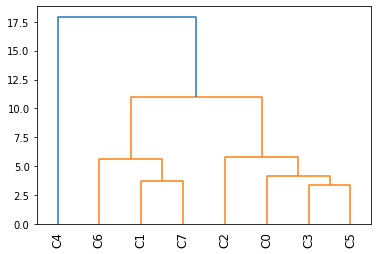

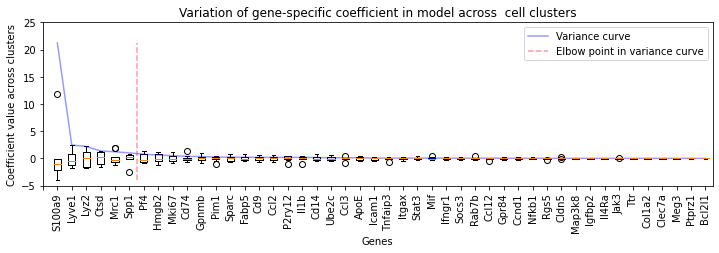

Gene	S100a9	Lyve1	Lyz2	Ctsd	Mrc1	Spp1
Var.	21.23	2.45	2.19	1.36	1.21	1.01


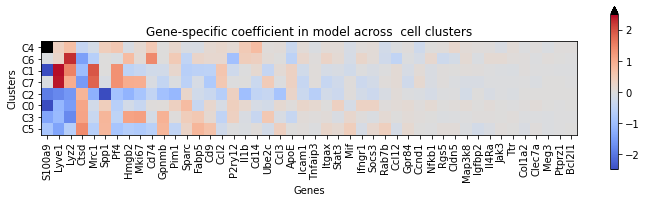

In [5]:
rfolder="results_targeted_standard__LogisticRegression/"

with open(rfolder+"LogisticRegression_model.pck", "rb") as f:
    model = pkl.load(f)
    
logit_model = model["estimator"]
print("Model coefficients: %d cell categories/clusters x %d genes from panel" % logit_model.coef_.shape)
mat, vars_clusters, gene_order, cluster_order, _ = compute_cluster_dendrogram(logit_model, plot_it=True)

plot_feature_by_variance(mat, vars_clusters, gene_order, targeted_panel, name="", figsize=(12,3))
plot_feature_coefficient(mat, vars_clusters, gene_order, cluster_order, targeted_panel, name="", figsize=(12,12))

According to those two plots, the genes which are most critical (with largest variance across cell clusters) to identify the cell cluster are S100a9, Lyve1, Lyz2, Ctsd, Mrc1 and Spp1.

### Variation of coefficients in microglia cell clusters

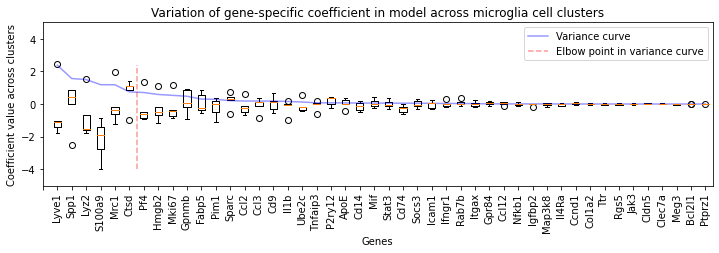

Gene	Lyve1	Spp1	Lyz2	S100a9	Mrc1	Ctsd
Var.	2.38	1.56	1.5	1.19	1.18	0.75


In [6]:
mat, vars_clusters, gene_order, _,  _ = compute_cluster_dendrogram(logit_model, restrict_to=["0","1","2","3","5"])

plot_feature_by_variance(mat, vars_clusters, gene_order, targeted_panel, 
                         name="microglia", figsize=(12,3), ylim=(-5,5))

### Variation of coefficients in non-microglia cell clusters

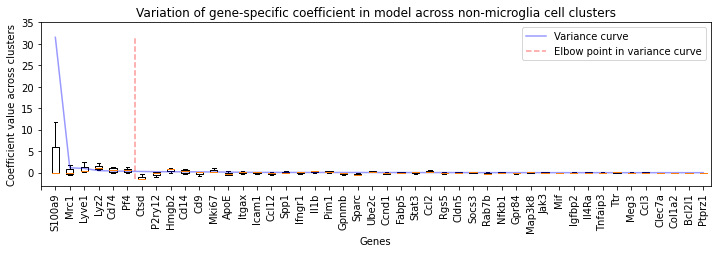

Gene	S100a9	Mrc1	Lyve1	Lyz2	Cd74	Pf4
Var.	31.54	1.14	0.98	0.48	0.39	0.33


In [7]:
mat, vars_clusters, gene_order, _, _ = compute_cluster_dendrogram(logit_model, restrict_to=["4","6","7"])

plot_feature_by_variance(mat, vars_clusters, gene_order, targeted_panel, 
                         name="non-microglia", figsize=(12,3), ylim=(-3,35))

## Cluster similarity based on coefficients

<Figure size 360x360 with 0 Axes>

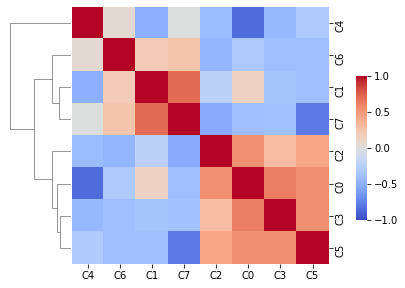

In [8]:
mat, vars_clusters, gene_order, _, linkage_data = compute_cluster_dendrogram(logit_model, plot_it=False)
plot_cluster_heatmap(mat, vars_clusters, gene_order, targeted_panel, linkage_data, figsize=(5,5))

## Signatures for microglia clusters

Using whole data on **predicted** (not ground truth!) clusters by the model, and applying a differential analysis

In [9]:
with open(rfolder+"LogisticRegression_model.pck", "rb") as f:
    model = pkl.load(f)
clf = model["estimator"]

## get sample annotation from *model*
with open(rfolder+"gene_list.pck", "rb") as f:
    di = pkl.load(f)
whole_panel = di["whole_panel"]
info_experience = pd.read_csv(dfolder+dfolder_files["metadata_whole"], index_col=0)
counts = pd.read_csv(rfolder+"raw_counts_subset_feature.csv", index_col=0)
counts = counts[[i for i in info_experience.index if (i in counts.columns)]].loc[whole_panel].dropna().T
X_fit, _ = data_normalisation(counts, "standard", counts)
Y_pred = clf.predict(X_fit).ravel()

np.random.seed(1234)
import random
random.seed(1234)

! pip install git+https://github.com/Maayanlab/geode.git
from geode import chdir
res_df_ls = []
for s in list(np.unique(Y_pred)):
    annotation = list((Y_pred==s).astype(int)+1)
    chdir_res = chdir(X_fit.T, annotation, whole_panel, calculate_sig=1, nnull=10000, sig_only=1)
    res_df = pd.DataFrame({"Statistic C%s" % s: {x[1]:x[0] for x in chdir_res}})
    res_df_ls.append(res_df)
res_df = res_df_ls[0].join(res_df_ls[1:], how="outer")
res_df

Number of significant genes: 30
Number of significant genes: 6
Number of significant genes: 41
Number of significant genes: 4
Number of significant genes: 7
Number of significant genes: 10
Number of significant genes: 6
Number of significant genes: 5


,Statistic C0,Statistic C1,Statistic C2,Statistic C3,Statistic C4,Statistic C5,Statistic C6,Statistic C7
Ccl2,-0.132651,0.196295,0.055466,NaN,NaN,NaN,NaN,NaN
Ccl3,0.153458,NaN,-0.182139,NaN,NaN,NaN,NaN,NaN
Cd14,-0.147615,NaN,-0.024717,NaN,0.194470,NaN,NaN,NaN
Cd9,0.086696,NaN,-0.131152,NaN,NaN,0.206786,NaN,NaN
Clec1a,0.078496,NaN,0.129389,NaN,NaN,NaN,NaN,NaN
Ctsd,0.101190,NaN,-0.044343,NaN,NaN,NaN,NaN,NaN
Fabp5,-0.247859,NaN,0.034000,NaN,NaN,0.471414,NaN,NaN
Gpr84,0.093508,NaN,0.038351,NaN,NaN,NaN,NaN,NaN
Hmgb2,-0.110875,NaN,-0.203829,0.428646,NaN,NaN,NaN,0.544891
Icam1,0.213932,NaN,-0.093973,NaN,NaN,NaN,NaN,NaN


### Is the quality of the gene panel for cluster identification stronger in microglia clusters?

In [10]:
res_df_bin = res_df.copy()
res_df_bin[~pd.isnull(res_df_bin)] = 1
res_df_bin = res_df_bin.fillna(0)
ptable = pd.DataFrame(res_df_bin.sum(axis=0), columns=["#significant genes"]).sort_values(by="#significant genes",
    ascending=False).astype(int)
ptable["is microglia"] = [
    int(any([("C%d"%c in i) and ("C%d0"%c not in i) and ("C%d1"%c not in i) for c in [0,2,3,5]
])) for i in ptable.index]

print(ptable.corr(method="spearman").values[0,1])
ptable

0.4390570399587614


,#significant genes,is microglia
Statistic C2,41,1
Statistic C0,30,1
Statistic C5,10,1
Statistic C4,7,0
Statistic C1,6,0
Statistic C6,6,0
Statistic C7,5,0
Statistic C3,4,1


There is a quite large positive correlation ($\rho > 0.4$) between having a lot of significant genes (for identification against other clusters among the 8) in the gene panel and being a microglia cell cluster, which seems to confirm what we visually observed when comparing non-microglia clusters and microglia clusters in the first heatmap, and in the last two boxplots.

### Visualization

In [11]:
def plot_predicted_foldchange(res_df,cluster_order,figsize=(12,12), maxval=0.7):
    plt.figure(figsize=figsize)
    plt.title("Genewise 'fold-change' (one-vs-other clusters) across model-predicted cell clusters")
    res_df_copy = res_df.copy().dropna(how="all")
    res_df_copy.columns = [x.split(" ")[1] for x in res_df_copy.columns]
    res_df_copy = res_df_copy[res_df_copy.columns[cluster_order]]
    gene_order = res_df_copy.var(axis=1, skipna=True).dropna().sort_values()
    res_df_copy = res_df_copy.loc[list(reversed(gene_order.index))] 
    c_map = copy(cm.get_cmap("coolwarm"))
    c_map.set_bad("lightgray")
    c_map.set_over("k")
    plt.imshow(res_df_copy.values.T, cmap=c_map, interpolation='none', vmin=-maxval, vmax=maxval)
    plt.xlabel("Genes")
    plt.ylabel("Clusters")
    plt.xticks(range(res_df_copy.shape[0]), res_df_copy.index, rotation=90)
    plt.yticks(range(res_df_copy.shape[1]), res_df_copy.columns)
    plt.colorbar(shrink=0.25, extend="max")
    plt.show()
    plt.close()

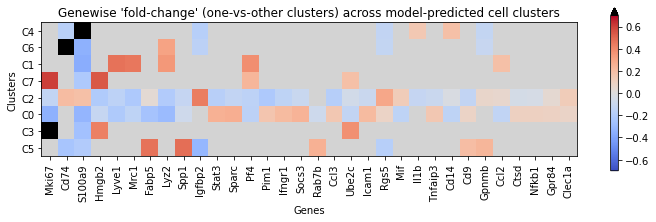

In [12]:
plot_predicted_foldchange(res_df,cluster_order,figsize=(12,12))